## Do albums reviewed as "Best New Music" have a consistent score threshold? In other words, is there a score beyond which an album is considered 'great'/'best' and is then added to their "Best New Music" page?


**Ha** : There is a significant scoring difference between "Best new music" flagged albums vs the rest.

**Ho** : There is no significant scoring difference between "Best new music" flagged albums vs the rest.


In [34]:
# Import necessary librairies
import sqlite3
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import random


import seaborn as sns
sns.set(color_codes=True)

In [37]:
# Connect to Pitchfork database
conn = sqlite3.Connection('database.sqlite')
c = conn.cursor()

In [38]:
# Retrieve list of distinct genres
c.execute("""
SELECT g.genre, AVG(r.score) as avg_score, COUNT(r.reviewid) as review_counter, SUM(r.best_new_music) as best_music_counter
FROM reviews as r, years as y, labels as l, genres as g
WHERE r.reviewid = y.reviewid
AND r.reviewid = l.reviewid
AND r.reviewid = g.reviewid
GROUP BY g.genre
ORDER BY avg_score DESC;
""")
genre_score_df = pd.DataFrame(c.fetchall())
genre_score_df.columns = [x[0] for x in c.description]
genre_score_df


,genre,avg_score,review_counter,best_music_counter
0,global,7.416418,268,12
1,experimental,7.371575,2044,158
2,jazz,7.341129,496,24
3,folk/country,7.226963,764,31
4,None,7.052846,2653,64
5,rock,6.991398,10858,737
6,metal,6.989896,960,31
7,electronic,6.935706,4341,244
8,pop/r&b,6.928631,1666,124
9,rap,6.904380,1872,114


In [40]:
# Getting an idea of the different genres and number of reviews per genre
c.execute("""
SELECT g.genre, r.*
FROM reviews as r, genres as g
WHERE r.reviewid = g.reviewid;
""")
reviews_df = pd.DataFrame(c.fetchall())
reviews_df.columns = [x[0] for x in c.description]
df.head()

,genre,reviewid,title,artist,url,score,best_new_music,author,author_type,pub_date,pub_weekday,pub_day,pub_month,pub_year
0,electronic,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,metal,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,rock,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,rock,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,electronic,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


/Users/francoisleralle/dev/anaconda/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/Users/francoisleralle/dev/anaconda/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/francoisleralle/dev/anaconda/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


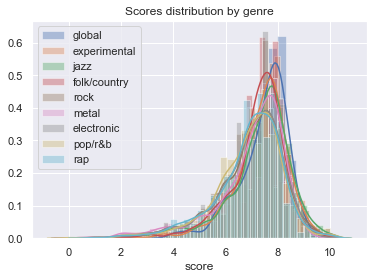

In [44]:
# Display scoring distribution by genre to see significant effect size in distribution means.
for genre in genre_score_df['genre']:
    # Retrieve genre dataset
    genre_df = df[df['genre'] == genre]
    sns.distplot(genre_df['score'], label=genre)

plt.legend()
plt.title('Scores distribution by genre');

In [24]:
# skewness and kurtosis
stats.skew(rap_df['score']), stats.kurtosis(rap_df['score'])

(-1.0885915395243293, 1.9928239233994844)